In [1]:
# !pip install geopy osmnx networkx mapclassify matplotlib prettytable

In [2]:
import osmnx

In [3]:
G = osmnx.graph_from_point((59.93893094417527, 30.32268115454809), dist=2500)

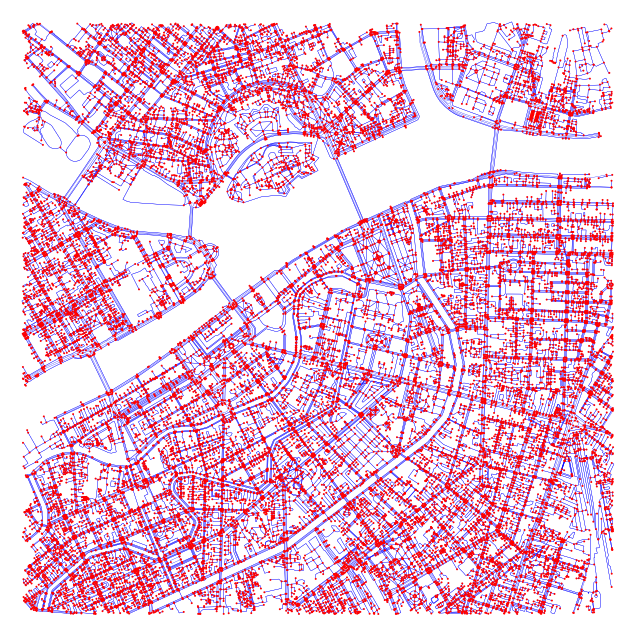

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
osmnx.plot.plot_graph(G, node_size=2, node_color='r', edge_color='b', edge_linewidth=0.2, bgcolor='white')

In [5]:
len(list(G.adjacency()))

29738

In [6]:
s = 365356365
t = 8518165879

In [7]:
shortest_path = osmnx.routing.shortest_path(G, s, t, weight='length')

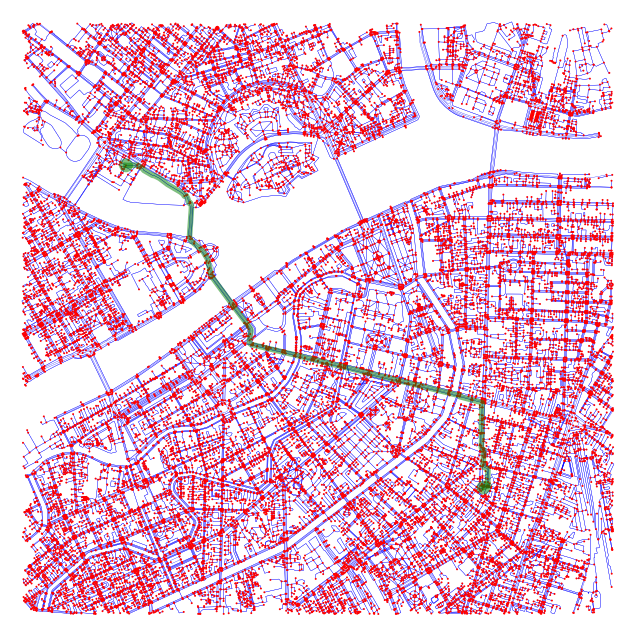

In [8]:
fig, ax = osmnx.plot.plot_graph_route(G, shortest_path, route_color='g', node_size=2, node_color='red', edge_color='b', edge_linewidth=0.2, bgcolor='white', close=True)
# fig.savefig("images/shortest_path_native.png")

In [9]:
from typing import Dict, List, Tuple, Set
from collections import Counter

def relax(graph: Dict[int, Dict[int, float]], u: int, v: int, distances: Dict[int, float], prev: Dict[int, int], labelled: Set, stats: Counter=None):
    if stats is not None:
        stats["relax_calls"] += 1
    if v not in distances or distances[v] > distances[u] + graph[u][v]:
        if stats is not None:
            stats["distance_updates"] += 1
        distances[v] = distances[u] + graph[u][v]
        prev[v] = u
        labelled.add(v)

def scan(graph: Dict[int, Dict[int, float]], node: int, distances: Dict[int, float], prev: Dict[int, int], labelled: Set, stats: Counter=None):
    if stats is not None:
        stats["scan_calls"] += 1
        
    for other, length in graph[node].items():
        relax(graph, node, other, distances, prev, labelled, stats)
    # labelled.remove(node)

def scanning_method(graph: Dict[int, Dict[int, float]], source: int, target: int = None, stats: Counter=None):
    distances = {source: 0}
    prev = dict()
    labelled = {source}
    while len(labelled) > 0:
        u = labelled.pop()
        if u == target:
            break
        scan(graph, u, distances, prev, labelled, stats)

    return distances, prev

In [10]:
def graph_from_osmnx(G):
    graph = dict()
    for n, adj in G.adjacency():
        if n not in graph:
            graph[n] = dict()
        for e, eattr in adj.items():
            for _, iattr in eattr.items():
                if e not in graph[n] or graph[n][e] > iattr["length"]:
                    graph[n][e] = iattr["length"]
    return graph

In [11]:
g = graph_from_osmnx(G)

In [12]:
basic_stats = Counter()
distances, prev = scanning_method(g, s, stats = basic_stats)
print(basic_stats)
print(distances[t])

Counter({'relax_calls': 1060170, 'distance_updates': 437690, 'scan_calls': 385509})
4875.546000000003


In [13]:
def print_route_and_visited(graph, source, target, distances, prev):
    route = [target]
    cur = target
    while cur != source:
        cur = prev[cur]
        route.append(cur)
    
    return osmnx.plot.plot_graph_route(G.subgraph(list(distances.keys())), list(reversed(route)), route_color='g', node_size=2, node_color='r', edge_color='b', edge_linewidth=0.2, bgcolor='white', close=True);


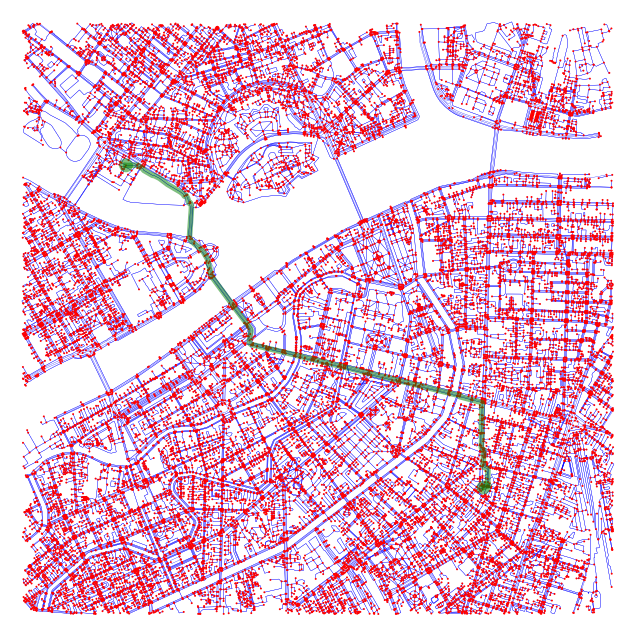

In [14]:
route = [t]
cur = t
while cur != s:
    cur = prev[cur]
    route.append(cur)
    
osmnx.plot.plot_graph_route(G, list(reversed(route)), route_color='g', node_size=2, node_color='r', edge_color='b', edge_linewidth=0.2, bgcolor='white');

In [15]:
def bellman_ford_moore(graph: Dict[int, Dict[int, float]],
                       source: int) -> Tuple[Dict[int, float], Dict[int, int]]:
    distances = {source: 0}
    prev = dict()
    changed = True
    for k in graph:
        if not changed:
            break
        changed = False
        for u, adjacent in graph.items():
            if u not in distances:
                continue
            for v, l in adjacent.items():
                if v not in distances or distances[v] > distances[u] + l:
                    distances[v] = distances[u] + l
                    prev[v] = u
                    changed = True

    return distances, prev

In [16]:
distances, prev = bellman_ford_moore(g, s)
print(distances[t])

4875.546000000003


In [17]:
def dijkstra(graph: Dict[int, Dict[int, float]],
             source: int,
             target: int = None,
             stats: Counter = None) -> Tuple[Dict[int, float], Dict[int, int]]:
    distances = {source: 0}
    prev = dict()
    labelled = {source}
    while len(labelled) > 0:
        u = min(labelled, key=lambda x: distances[x])
        labelled.remove(u)
        if u == target:
            break
        scan(graph, u, distances, prev, labelled, stats)

    return distances, prev

In [18]:
dijkstra_stats = Counter()
distances, prev = dijkstra(g, s, stats = dijkstra_stats)
print(dijkstra_stats)
print(distances[t])

Counter({'relax_calls': 81090, 'distance_updates': 34065, 'scan_calls': 29730})
4875.546000000003


In [19]:
truncated_dijkstra_stats = Counter()
distances, prev = dijkstra(g, s, t, stats = truncated_dijkstra_stats)
print(truncated_dijkstra_stats)
print(distances[t])

Counter({'relax_calls': 69189, 'distance_updates': 29155, 'scan_calls': 25211})
4875.546000000003


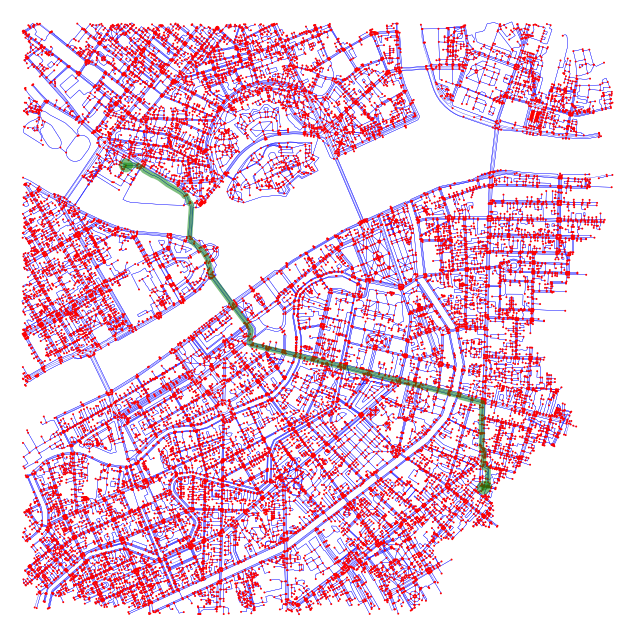

In [20]:
fig, ax = print_route_and_visited(G, s, t, distances, prev)
# fig.savefig("images/truncated_dijkstra.png")

In [21]:
import math
import geopy.distance

def geo_dist(graph, u, v):
    coords_1 = (graph.nodes[u]['y'], graph.nodes[u]['x'])
    coords_2 = (graph.nodes[v]['y'], graph.nodes[v]['x'])

    return geopy.distance.distance(coords_1, coords_2).m

print(geo_dist(G, s, t))

4087.534306351567


In [22]:
def a_star(graph: Dict[int, Dict[int, float]],
           source: int,
           target: int,
           graphnx,
           stats: Counter=None) -> Tuple[Dict[int, float], Dict[int, int]]:
    distances = {source: 0}
    prev = dict()
    potentials = dict() 
    labelled = {source}
    while len(labelled) > 0:
        u = -1
        best = -1
        for v in labelled:
            if v not in potentials:
                potentials[v] = geo_dist(graphnx, v, target)
            if u == -1 or distances[v] + potentials[v] < best:
                best = potentials[v] + distances[v]
                u = v
        # print(u)
        labelled.remove(u)
        if u == target:
            break
        scan(graph, u, distances, prev, labelled, stats)

    return distances, prev

In [23]:
a_star_stats = Counter()
distances, prev = a_star(g, s, t, G, stats = a_star_stats)
print(a_star_stats)
print(distances[t])

Counter({'relax_calls': 13100, 'distance_updates': 5904, 'scan_calls': 4764})
4875.546000000003


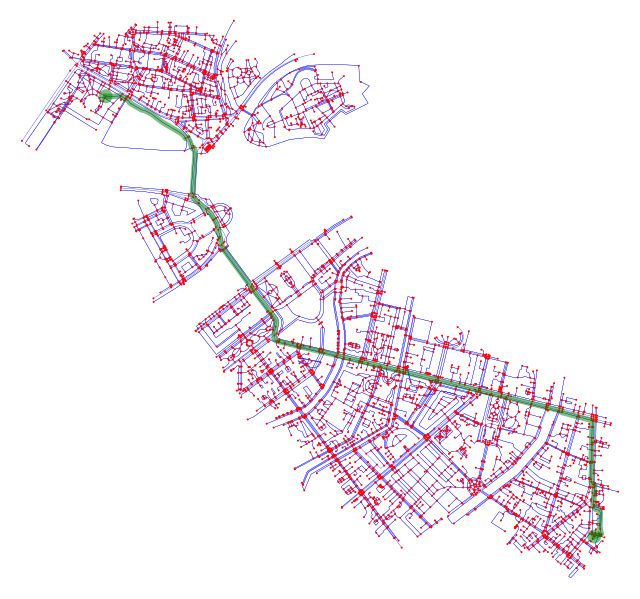

In [24]:
fig, ax = print_route_and_visited(G, s, t, distances, prev)
# fig.savefig("images/astar.png")

In [25]:
def reversed_graph(graph: Dict[int, Dict[int, float]]) -> Dict[int, Dict[int, float]]:
    rev_graph = {v: dict() for v in graph}
    for v, adj in graph.items():
        for u, l in adj.items():
            rev_graph[u][v] = l
    return rev_graph

In [26]:
def bidir_dijkstra(graph: Dict[int, Dict[int, float]],
                   source: int,
                   target: int,
                   stats: Counter=None) -> Tuple[Dict[int, float], Dict[int, int]]:
    rev_graph = reversed_graph(graph)
    distances_f = {source: 0}
    prev_f = dict()
    distances_b = {target: 0}
    prev_b = dict()
    scanned_f = set()
    scanned_b = set()
    
    labelled_f = {source}
    labelled_b = {target}

    best = float("inf")
    best_f = source
    best_b = target

    u = source
    v = target
    
    while len(labelled_f) > 0 or len(labelled_b):
        if distances_f[u] < distances_b[v]:
            if u in scanned_b:
                break
            labelled_f.remove(u)
            scan(graph, u, distances_f, prev_f, labelled_f, stats)
            for p, l in graph[u].items():
                if p in distances_b and distances_f[u] + distances_b[p] + l < best:
                    best_f = u
                    best_b = p
                    best =  distances_f[u] + distances_b[p] + l
            scanned_f.add(u)
            u = min(labelled_f, key=lambda x: distances_f[x])
        else:
            if v in scanned_f:
                break
            labelled_b.remove(v)
            scan(rev_graph, v, distances_b, prev_b, labelled_b, stats)
            for p, l in rev_graph[v].items():
                if p in distances_f and distances_b[v] + distances_f[p] + l < best:
                    best_f = p
                    best_b = v
                    best =  distances_b[v] + distances_f[p] + l
            scanned_b.add(v)
            v = min(labelled_b, key=lambda x: distances_b[x])

    best_path = [best_f]
    cur = best_f
    while cur != source:
        cur = prev_f[cur]
        best_path.append(cur)
    best_path = list(reversed(best_path))

    cur = best_b
    if cur != best_path[-1]:
        best_path.append(cur)
    while cur != target:
        cur = prev_b[cur]
        best_path.append(cur)
    
    return distances_f, distances_b, prev_f, prev_b, best_path, best

In [27]:
bidir_dijkstra_stats = Counter()
distances_f, distances_b, prev_f, prev_b, best_path, best = bidir_dijkstra(g, s, t, stats = bidir_dijkstra_stats)
print(bidir_dijkstra_stats)
print(best)

Counter({'relax_calls': 52701, 'distance_updates': 22416, 'scan_calls': 19307})
4875.546000000002


In [28]:
fig, ax = osmnx.plot.plot_graph_route(G.subgraph(list(distances_f.keys()) + list(distances_b.keys())), best_path, route_color='g', node_size=2, node_color='r', edge_color='b', edge_linewidth=0.2, bgcolor='white', show=False);
# fig.savefig("images/bidir_dijkstra.png")

In [29]:
def bidir_a_star(graph: Dict[int, Dict[int, float]],
                 source: int,
                 target: int,
                 graphnx,
                 stats: Counter=None) -> Tuple[Dict[int, float], Dict[int, int]]:
    rev_graph = reversed_graph(graph)
    distances_f = {source: 0}
    prev_f = dict()
    distances_b = {target: 0}
    prev_b = dict()
    scanned_f = set()
    scanned_b = set()
    
    labelled_f = {source}
    labelled_b = {target}

    best = float("inf")
    best_f = source
    best_b = target

    u = source
    v = target
    potentials = dict()
    
    while len(labelled_f) > 0 or len(labelled_b):
        if distances_f[u] < distances_b[v]:
            if u in scanned_b:
                break
            labelled_f.remove(u)
            scan(graph, u, distances_f, prev_f, labelled_f, stats)
            for p, l in graph[u].items():
                if p in distances_b and distances_f[u] + distances_b[p] + l < best:
                    best_f = u
                    best_b = p
                    best =  distances_f[u] + distances_b[p] + l
            scanned_f.add(u)
            for x in labelled_f:
                if x not in potentials:
                    potentials[x] = 0.5 * (geo_dist(graphnx, x, target) - geo_dist(graphnx, x, source))
            u = min(labelled_f, key=lambda x: distances_f[x] + potentials[x])
        else:
            if v in scanned_f:
                break
            labelled_b.remove(v)
            scan(rev_graph, v, distances_b, prev_b, labelled_b, stats)
            for p, l in rev_graph[v].items():
                if p in distances_f and distances_b[v] + distances_f[p] + l < best:
                    best_f = p
                    best_b = v
                    best =  distances_b[v] + distances_f[p] + l
            scanned_b.add(v)
            for x in labelled_b:
                if x not in potentials:
                    potentials[x] = 0.5 * (geo_dist(graphnx, x, target) - geo_dist(graphnx, x, source))
            v = min(labelled_b, key=lambda x: distances_b[x] - potentials[x])

    best_path = [best_f]
    cur = best_f
    while cur != source:
        cur = prev_f[cur]
        best_path.append(cur)
    best_path = list(reversed(best_path))

    cur = best_b
    if cur != best_path[-1]:
        best_path.append(cur)
    while cur != target:
        cur = prev_b[cur]
        best_path.append(cur)
    
    return distances_f, distances_b, prev_f, prev_b, best_path, best

In [30]:
bidir_a_star_stats = Counter()
distances_f, distances_b, prev_f, prev_b, best_path, best = bidir_a_star(g, s, t, G, stats = bidir_a_star_stats)
print(bidir_a_star_stats)
print(f"{best:.2f}")

Counter({'relax_calls': 8858, 'distance_updates': 4160, 'scan_calls': 3203})
4875.55


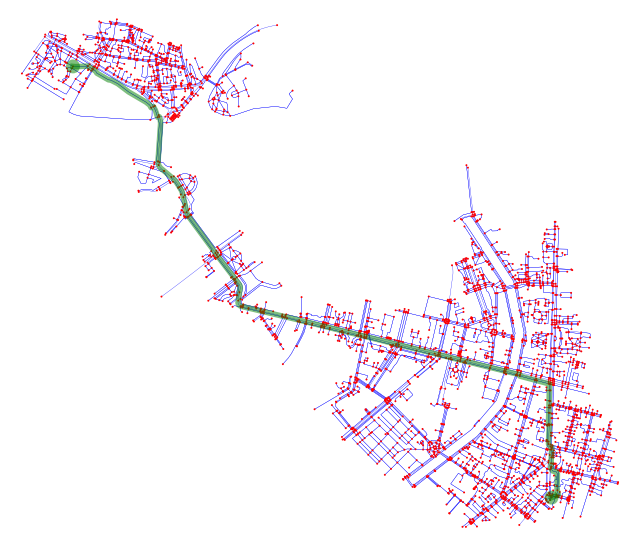

In [31]:
fig, ax = osmnx.plot.plot_graph_route(G.subgraph(list(distances_f.keys()) + list(distances_b.keys())),
                                      best_path,
                                      route_color='g',
                                      node_size=2,
                                      node_color='r',
                                      edge_color='b',
                                      edge_linewidth=0.2,
                                      bgcolor='white')
# fig.savefig("images/bidir_a_star.png")

In [32]:
import heapq

def k_shortest_path_looply(graph: Dict[int, Dict[int, float]],
                           source: int,
                           target: int,
                           k: int,
                           min_loop_length: int = 1) -> List[List[int]]:
    distances_b, _ = dijkstra(reversed_graph(graph), target)
    result = []
    sorted_adjacency = dict() # Dict[List[Tuple[int, float]]]
    entries = [(source, -1, 0)] # vertex_id, parent entry, sorted adjacency position
    path_queue = [(0, 0)] # reduced length, -entry_id 

    while len(result) < k:
        length, entry_id_rev = heapq.heappop(path_queue)
        entry_id = -entry_id_rev
        v, parent_entry, pos = entries[entry_id]
        if v == target:
            cur = entry_id
            path = [target]
            while cur != 0:
                cur = entries[cur][1]
                path.append(entries[cur][0])
            result.append(list(reversed(path)))

    
        if v not in sorted_adjacency:
            sorted_adjacency[v] = list(sorted(graph[v].items(), key=lambda x: x[1] + distances_b[x[0]]))
        if parent_entry != -1 and pos < len(sorted_adjacency[entries[parent_entry][0]]) - 1:
            u, length = sorted_adjacency[entries[parent_entry][0]][pos + 1]
            cur = parent_entry            
            if not has_cycle:    
                entries.append((u, parent_entry, pos + 1))
                heapq.heappush(path_queue, (length + distances_b[u] - distances_b[entries[parent_entry][0]], 1 - len(entries)))

        if len(sorted_adjacency) > 0:
            u, length = sorted_adjacency[v][0]
            has_cycle = False
            cur = entry_id
            for i in range(min_loop_length - 1):
                if cur == 0:
                    break
                if entries[cur][0] == u:
                    has_cycle = True
                    break
                cur = entries[cur][1]
            if not has_cycle:
                entries.append((u, entry_id, 0))
                heapq.heappush(path_queue, (length + distances_b[u] - distances_b[v], 1 - len(entries)))

    return result

In [33]:
paths = k_shortest_path_looply(g, s, t, 10, 5)

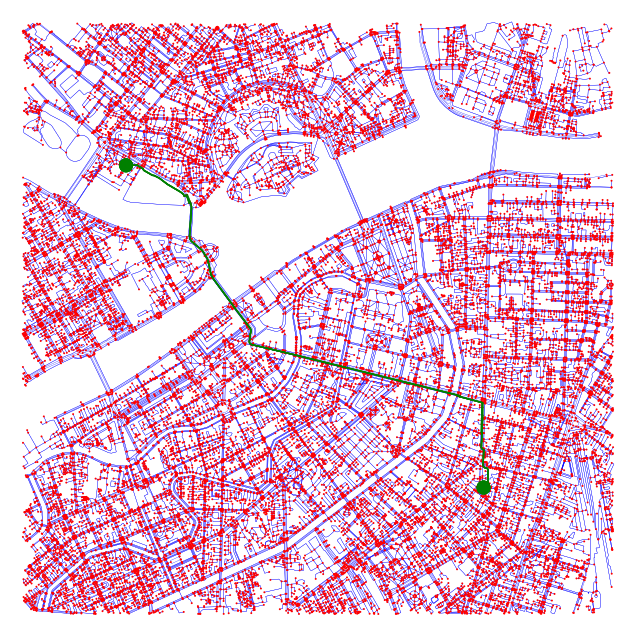

In [34]:
fig, ax = osmnx.plot.plot_graph_routes(G,
                                      paths,
                                      route_linewidths=1,
                                      route_colors='g',
                                      node_size=2,
                                      node_color='r',
                                      edge_color='b',
                                      edge_linewidth=0.2,
                                      bgcolor='white')

In [35]:
def best_path_subgraph(graph: Dict[int, Dict[int, float]],
                       source: int,
                       target: int,
                       beam: float) -> List[Tuple[int, int]]:
    distances_f, _ = dijkstra(graph, source)
    distances_b, _ = dijkstra(reversed_graph(graph), target)
    best = distances_f[target]

    edges = []
    for u, adj in graph.items():
        if u not in distances_f:
            continue
        for v, length in adj.items():
            if v not in distances_b:
                continue
            if distances_f[u] + length + distances_b[v] < best + beam:
                edges.append((u, v))
    return edges

In [36]:
edges = best_path_subgraph(g, s, t, 500)

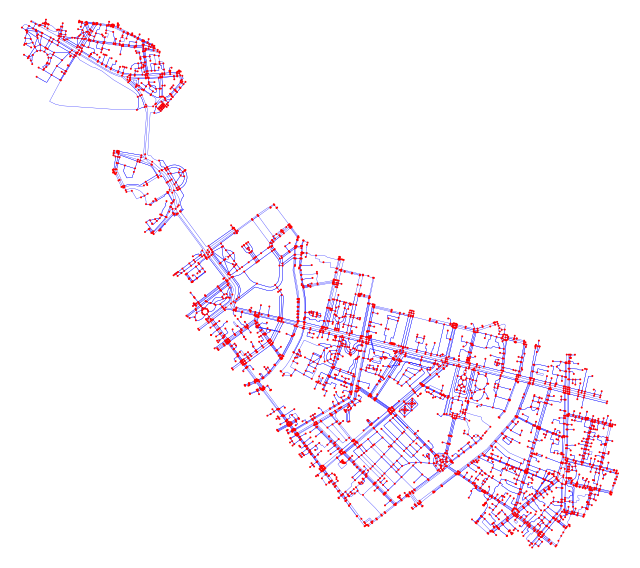

In [37]:
fig, ax = osmnx.plot.plot_graph(G.edge_subgraph([(u, v, 0) for u, v in edges]),
                                node_size=2,
                                node_color='r',
                                edge_color='b',
                                edge_linewidth=0.2,
                                bgcolor='white')
# fig.savefig("images/best_path_subgraph.png")

In [38]:
top = max([u['y'] for u in G.nodes.values()])
bot = min([u['y'] for u in G.nodes.values()])
left = min([u['x'] for u in G.nodes.values()])
right = max([u['x'] for u in G.nodes.values()])

top_nodes = sorted([u for u, attr in G.nodes.items() if attr['y'] > top - (top - bot) / 100], key=lambda u: G.nodes[u]['x'])
bot_nodes = sorted([u for u, attr in G.nodes.items() if attr['y'] < bot + (top - bot) / 100], key=lambda u: G.nodes[u]['x'])
left_nodes = sorted([u for u, attr in G.nodes.items() if attr['x'] < left + (right - left) / 100], key=lambda u: G.nodes[u]['y'])
right_nodes = sorted([u for u, attr in G.nodes.items() if attr['x'] > right - (right - left) / 100], key=lambda u: G.nodes[u]['y'])

landmarks = []
for node_list in [top_nodes, bot_nodes, left_nodes, right_nodes]:
    for i in range(0, len(node_list), len(node_list) // 10):
        landmarks.append(node_list[i])

landmarks_adj = []
for u in landmarks:
    landmarks_adj.append(u)
    for v, attr in G[u].items():
        landmarks_adj.append(v)

In [39]:
landmark_distances = dict()
for u in landmarks:
    distances_f, _ = dijkstra(g, u)
    if s not in distances_f:
        continue
    if t not in distances_f:
        continue
    landmark_distances[u] = distances_f

In [40]:
def alt(graph: Dict[int, Dict[int, float]],
        source: int,
        target: int,
        landmark_distances,
        stats: Counter=None):
    rev_graph = reversed_graph(graph)
    distances_f = {source: 0}
    prev_f = dict()
    distances_b = {target: 0}
    prev_b = dict()
    scanned_f = set()
    scanned_b = set()
    
    labelled_f = {source}
    labelled_b = {target}

    best = float("inf")
    best_f = source
    best_b = target

    u = source
    v = target
    potentials = dict()
    
    while len(labelled_f) > 0 or len(labelled_b):
        if distances_f[u] < distances_b[v]:
            if u in scanned_b:
                break
            labelled_f.remove(u)
            scan(graph, u, distances_f, prev_f, labelled_f, stats)
            for p, l in graph[u].items():
                if p in distances_b and distances_f[u] + distances_b[p] + l < best:
                    best_f = u
                    best_b = p
                    best =  distances_f[u] + distances_b[p] + l
            scanned_f.add(u)
            for x in labelled_f:
                if x not in potentials:
                    potential_f = 0
                    potential_b = 0
                    for p in landmark_distances:
                        potential_f = max(potential_f, landmark_distances[p][target] - landmark_distances[p][x])
                        potential_b = max(potential_b, landmark_distances[p][x] - landmark_distances[p][source])                  
                    potentials[x] = 0.5 * (potential_f - potential_b)
                        
            u = min(labelled_f, key=lambda x: distances_f[x] + potentials[x])
        else:
            if v in scanned_f:
                break
            labelled_b.remove(v)
            scan(rev_graph, v, distances_b, prev_b, labelled_b, stats)
            for p, l in rev_graph[v].items():
                if p in distances_f and distances_b[v] + distances_f[p] + l < best:
                    best_f = p
                    best_b = v
                    best =  distances_b[v] + distances_f[p] + l
            scanned_b.add(v)
            for x in labelled_b:
                if x not in potentials:
                    potential_f = 0
                    potential_b = 0
                    for p in landmark_distances:
                        potential_f = max(potential_f, landmark_distances[p][target] - landmark_distances[p][x])
                        potential_b = max(potential_b, landmark_distances[p][x] - landmark_distances[p][source])                  
                    potentials[x] = 0.5 * (potential_f - potential_b)
            v = min(labelled_b, key=lambda x: distances_b[x] - potentials[x])

    best_path = [best_f]
    cur = best_f
    while cur != source:
        cur = prev_f[cur]
        best_path.append(cur)
    best_path = list(reversed(best_path))

    cur = best_b
    if cur != best_path[-1]:
        best_path.append(cur)
    while cur != target:
        cur = prev_b[cur]
        best_path.append(cur)
    
    return distances_f, distances_b, best_path, best

In [41]:
alt_stats = Counter()
distances_f, distances_b, best_path, best = alt(g, s, t, landmark_distances, stats = alt_stats)
print(alt_stats)
print(f"{best:.2f}")

Counter({'relax_calls': 1231, 'distance_updates': 671, 'scan_calls': 463})
4875.55


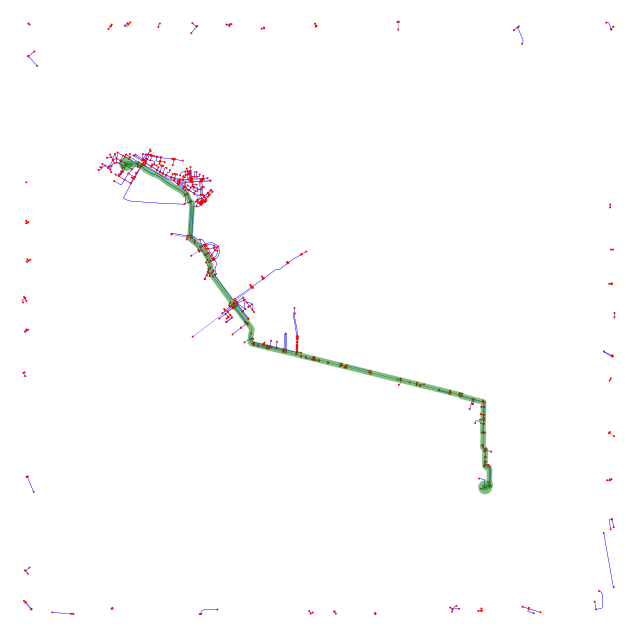

In [42]:
fig, ax = osmnx.plot.plot_graph_route(G.subgraph(list(distances_f.keys()) + list(distances_b.keys()) + landmarks_adj),
                                      best_path,
                                      route_color='g',
                                      node_size=2,
                                      node_color='r',
                                      edge_color='b',
                                      edge_linewidth=0.2,
                                      bgcolor='white')
# fig.savefig("images/art.png")

In [43]:
import prettytable

stats_table = prettytable.PrettyTable()
stats_all = {
    "basic": basic_stats,
    "dijkstra": dijkstra_stats,
    "bidir_dijkstra": bidir_dijkstra_stats,
    "a_star": a_star_stats,
    "bidir_a_star": bidir_a_star_stats,
    "alt": alt_stats
}

stats_table.field_names = ["Method", "Relax calls", "Distance updates", "Scan calls"]
for name, stats in stats_all.items():
    stats_table.add_row([name, stats["relax_calls"], stats["distance_updates"], stats["scan_calls"]])
stats_table
print(stats_table)

+----------------+-------------+------------------+------------+
|     Method     | Relax calls | Distance updates | Scan calls |
+----------------+-------------+------------------+------------+
|     basic      |   1060170   |      437690      |   385509   |
|    dijkstra    |    81090    |      34065       |   29730    |
| bidir_dijkstra |    52701    |      22416       |   19307    |
|     a_star     |    13100    |       5904       |    4764    |
|  bidir_a_star  |     8858    |       4160       |    3203    |
|      alt       |     1231    |       671        |    463     |
+----------------+-------------+------------------+------------+
